In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [9, 6]

import sys
sys.path.append("incl/")

import noror
import narrom

In [5]:
trajectories = narrom.utils.load_trajectories(filename='/home/agluedge/Preprints/ELPH/runs/runs_n_kmax=200.npz')

trajectories = trajectories[::10]

for k in range(len(trajectories)):
    trajectories[k] = trajectories[k].T

n_trajectories = len(trajectories)
n_kmax = trajectories[0].shape[1]

print(n_trajectories, 'loaded with n_kmax =', n_kmax)

100 loaded with n_kmax = 200


runs[0] shape:  (400, 200)


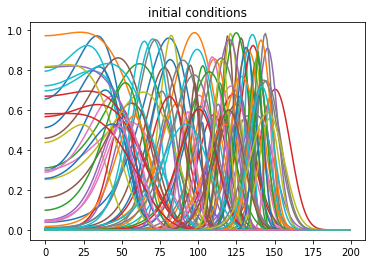

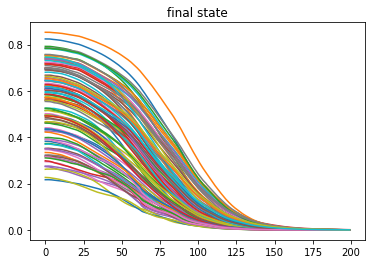

In [6]:
print('runs[0] shape: ', trajectories[0].shape)

for k in range(n_trajectories):
    plt.plot(trajectories[k][0])

plt.title('initial conditions')
plt.show()


for k in range(n_trajectories):
    plt.plot(trajectories[k][-1])

plt.title('final state')
plt.show()

In [62]:
dim_reducer = narrom.dim_reducer.SVD()
# dim_reducer = narrom.dim_reducer.DFT(sorted=True)
# dim_reducer = narrom.dim_reducer.Hermite(sample_max = 1.0, sorted=True, optimize=True, orthogonalize=True, train_rdim=20)

# scaler = narrom.scaler.normalize_scaler(0.1)
scaler = narrom.scaler.standardize_scaler(1.0)
# scaler = narrom.scaler.tanh_scaler(0.1)

# transformer = narrom.transformer.polynomial_features(order=2)
transformer = narrom.transformer.ELM_features(ELM_nodes=400)

optimizer = narrom.optimizer.ridge(alpha=10.**-3)
# optimizer = narrom.optimizer.lstsqrs()
# optimizer = narrom.optimizer.stlsq(alpha=10.**-3, threshold=1e-3)
# optimizer = narrom.optimizer.PIML_adam(dim_reducer=dim_reducer, alpha=1e-3, lambda1=100000, mini_batch_size=39000, epochs = 100)

model = noror.noror(trajectories, targets='AR', VAR_l=2, intercept=True, full_hist=False,
                    optimizer=optimizer,
                    scaler=scaler,
                    dim_reducer=dim_reducer,
                    VAR_transformer=transformer)

model.train(rdim=15)

model.print_status()


full_hist:  False
intercept:  True
standardize:  True
rdim:  15
VAR_l:  2
train shape:  (39900, 431)
target shape:  (39900, 15)
weights shape:  (431, 15)


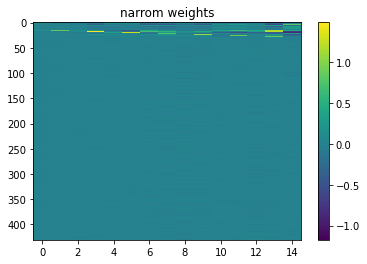

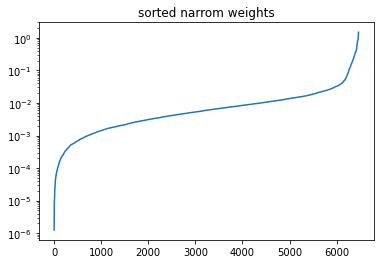

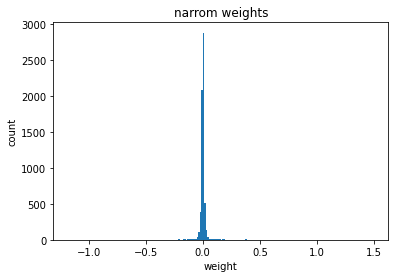

In [46]:
masked_weights = np.ma.masked_values(model.w,0.0)
plt.imshow(masked_weights, aspect='auto', interpolation='none')
plt.colorbar()
plt.title('narrom weights')
plt.show()

plt.semilogy(np.sort(np.ravel(np.abs(model.w))))
plt.title('sorted narrom weights')
plt.show()

plt.hist(np.ravel(model.w), bins=200)
plt.title('narrom weights')
plt.xlabel('weight')
plt.ylabel('count')
plt.show()

In [10]:

test_trajectory = narrom.utils.load_trajectories(filename='/home/agluedge/Preprints/ELPH/example_run.npz')[0].T
print('example trajectory loaded with shape: ', test_trajectory.shape)


example trajectory loaded with shape:  (400, 200)


In [17]:
test_trajectory = trajectories[17]

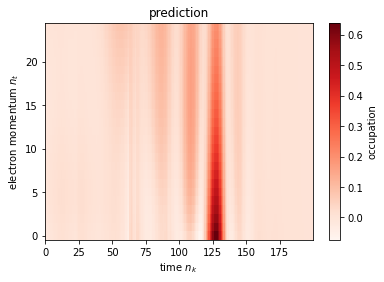

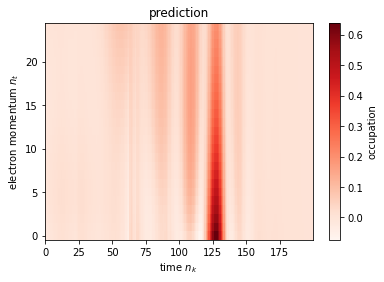

In [75]:
pred = model.forecast(test_trajectory[:1],25)
    
narrom.utils.plot_trajectory(pred,'prediction')


pred_mod = model.forecast_mod(test_trajectory[:1],25)
    
narrom.utils.plot_trajectory(pred_mod,'prediction')


In [40]:
pred = model.predict(test_trajectory)

print('std error: ', model.get_error(test_trajectory, pred=pred, norm='NF') )
print('max error: ', model.get_error(test_trajectory, pred=pred, norm='max') )

std error:  0.02099457502682776
max error:  0.12525931891672037


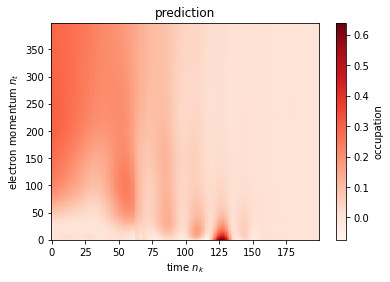

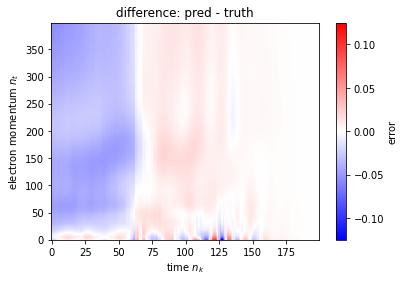

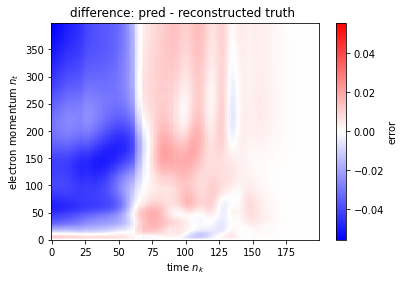

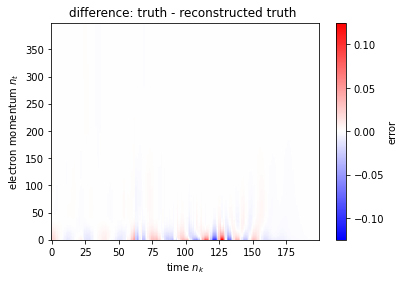

In [41]:

narrom.utils.plot_trajectory(pred, 'prediction')

narrom.utils.plot_difference(pred,test_trajectory,'difference: pred - truth')


test_trajectory_SVDapprx = dim_reducer.reconstruct( dim_reducer.reduce(test_trajectory,15) )

narrom.utils.plot_difference(pred,test_trajectory_SVDapprx,'difference: pred - reconstructed truth ')

narrom.utils.plot_difference(test_trajectory,test_trajectory_SVDapprx,'difference: truth - reconstructed truth ')


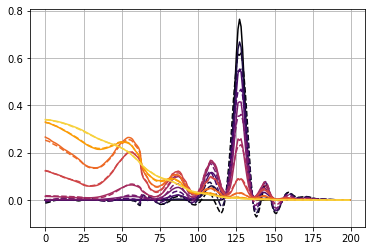

NF error:  0.0
max abs error:  0.0


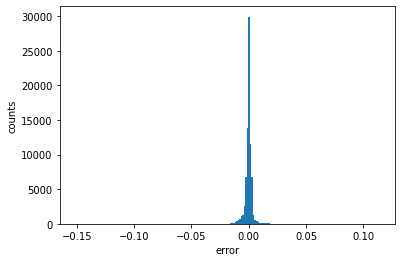

In [14]:
pl_colors = plt.get_cmap('inferno')

tn_arr = [0,2,5,10,20,50,100,200,399]

plt.grid()

for k,tn in enumerate(tn_arr):
    plt.plot(test_trajectory[tn], '-', c=pl_colors(k/len(tn_arr)))
    plt.plot(pred[tn], '--', c=pl_colors(k/len(tn_arr)))

plt.show()

print('NF error: ', model.get_error(test_trajectory, pred, norm='NF') )
print('max abs error: ', model.get_error(test_trajectory, pred, norm='max') )

plt.hist(np.ravel(pred-test_trajectory), bins = 200)
plt.xlabel('error')
plt.ylabel('counts')
plt.show()

In [16]:
dim_reducer = narrom.dim_reducer.SVD()

# scaler = narrom.scaler.normalize_scaler(0.1)
scaler = narrom.scaler.standardize_scaler(1.0)

# transformer = narrom.transformer.polynomial_features(order=2)
transformer = narrom.transformer.ELM_features(ELM_nodes=400)

optimizer = narrom.optimizer.ridge(alpha=10.**-3.0)

model = noror.noror(trajectories, targets='AR', VAR_l=2, intercept=True, full_hist=False, 
                      optimizer=optimizer,
                      scaler=scaler,
                      dim_reducer=dim_reducer,
                      VAR_transformer=transformer)

train_kwargs = {'rdim':15}

scores = narrom.utils.get_KFold_CV_scores(model, trajectories, folds=10, seed=817,
                                          norms=['NF','max'],
                                          train_kwargs=train_kwargs)

print('NF error: ', str(np.mean(scores[0])) + ' +- ' + str(np.std(scores[0])) )
print('max error: ', str(np.mean(scores[1])) + ' +- ' + str(np.std(scores[1])) )

NF error:  0.006061179869494421 +- 0.004413856447553979
max error:  0.04728332304677254 +- 0.044282831214616875


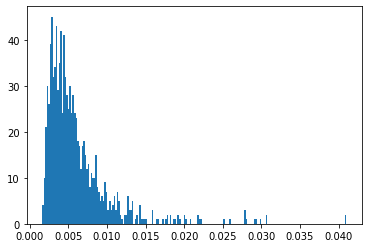

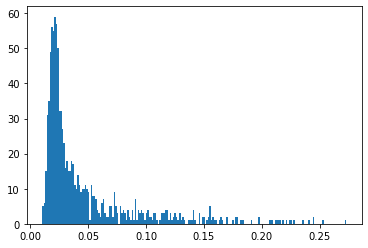

In [17]:
plt.hist(scores[0],bins=200)
plt.show()

plt.hist(scores[1],bins=200)
plt.show()

full_hist:  False
intercept:  True
standardize:  True
rdim:  20
prdim:  20
VAR_l:  2
train shape:  (399000, 861)
target shape:  (399000, 20)
weights shape:  (861, 20)
NF error:  0.007604513620717341
max error:  0.03200846913700883


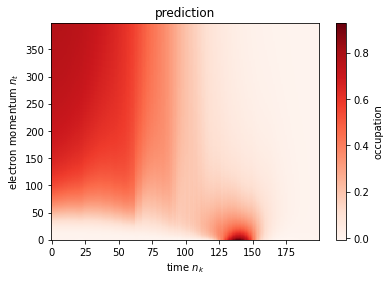

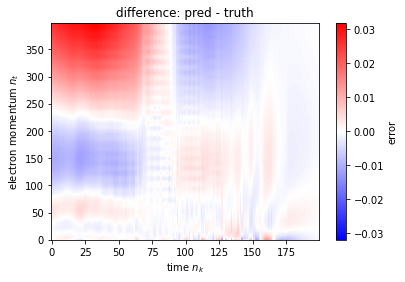

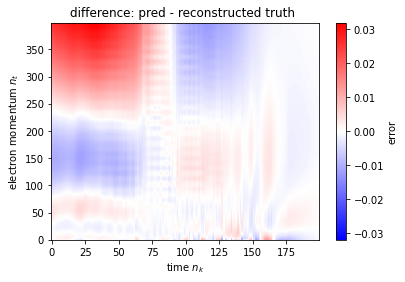

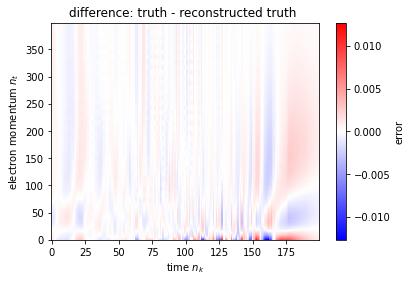

In [9]:
dim_reducer = narrom.dim_reducer.SVD()
scaler = narrom.scaler.normalize_scaler(0.1)
transformer = narrom.transformer.polynomial_features(order=2)
optimizer = narrom.optimizer.ridge(alpha=10.**-3.5)

training_trajectories = trajectories[::1]
popped_test_trajectory = training_trajectories.pop(73)


model = narrom.narrom(trajectories, VAR_l=2, intercept=True, full_hist=False, optimizer=optimizer, scaler=scaler, dim_reducer=dim_reducer, VAR_transformer=transformer)

model.train(rdim=20, prdim = 20)

model.print_status()

pred = model.predict_test_trajectory(popped_test_trajectory)

print('NF error: ', model.get_error(popped_test_trajectory, pred, norm='NF') )
print('max error: ', model.get_error(popped_test_trajectory, pred, norm='max') )




narrom.utils.plot_trajectory(pred, 'prediction')

narrom.utils.plot_difference(pred,popped_test_trajectory,'difference: pred - truth')


reconstructed_popped_test_trajectory = dim_reducer.reconstruct( dim_reducer.reduce(popped_test_trajectory,20) )

narrom.utils.plot_difference(pred,popped_test_trajectory,'difference: pred - reconstructed truth ')

narrom.utils.plot_difference(popped_test_trajectory,reconstructed_popped_test_trajectory,'difference: truth - reconstructed truth ')



In [4]:
print(type(trajectories))

<class 'list'>


In [20]:
import random

n_train_traj = [10,20,50,100,200,500,1000]

scores_list = []

for n in n_train_traj:
    
    print(n)

#     train_traj = random.sample(trajectories,n)
    train_traj = trajectories.copy()[:n]


    dim_reducer = narrom.dim_reducer.SVD()

#     scaler = narrom.scaler.normalize_scaler(0.1)
    scaler = narrom.scaler.standardize_scaler(1.0)

#     transformer = narrom.transformer.polynomial_features(order=2)
    transformer = narrom.transformer.ELM_features(ELM_nodes=400)

    optimizer = narrom.optimizer.ridge(alpha=10.**-3.0)

    model = narrom.narrom(train_traj, VAR_l=2, intercept=True, full_hist=False, optimizer=optimizer, scaler=scaler, dim_reducer=dim_reducer, VAR_transformer=transformer)

    train_kwargs = {'rdim':15, 'prdim':15}

    scores = narrom.utils.get_KFold_CV_scores(model, train_traj, folds=10, seed=817, norms=['NF','max'], train_kwargs=train_kwargs)

    print('NF error: ', str(np.mean(scores[0])) + ' +- ' + str(np.std(scores[0])) )
    print('max error: ', str(np.mean(scores[1])) + ' +- ' + str(np.std(scores[1])) )
    
    scores_list.append(scores)

10
NF error:  0.12142763137687496 +- 0.03973737697535043
max error:  0.44194700084816085 +- 0.10852356763528052
20
NF error:  0.1506907203089876 +- 0.05584062966207423
max error:  0.4458705037328272 +- 0.11852214964542078
50
NF error:  0.02976837107090429 +- 0.0233349571467255
max error:  0.11570914649352382 +- 0.07320021655553477
100
NF error:  0.01462301115382479 +- 0.011317178543417333
max error:  0.06625268617710663 +- 0.04995983435447383
200
NF error:  0.00874846451857751 +- 0.007323982024695112
max error:  0.05235172515631753 +- 0.0452131806780741
500
NF error:  0.006589777820490397 +- 0.005268953733498176
max error:  0.048665267035397246 +- 0.0457744143127212
1000
NF error:  0.006061054879117824 +- 0.004413582002286595
max error:  0.047282977340428405 +- 0.044282589825699756


In [21]:
NF_mean = [np.mean(scrs[0]) for scrs in scores_list ]
NF_std  = [np.std(scrs[0]) for scrs in scores_list ]

max_mean = [np.mean(scrs[1]) for scrs in scores_list ]
max_std  = [np.std(scrs[1]) for scrs in scores_list ]

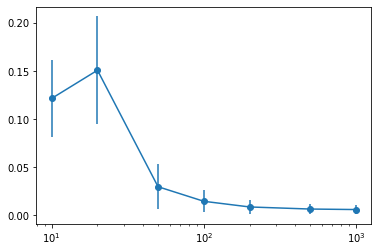

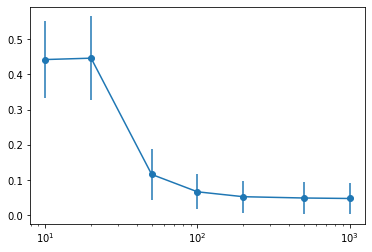

In [22]:
plt.errorbar(n_train_traj, NF_mean, yerr=NF_std, marker = 'o')
plt.xscale('log')
plt.show()

plt.errorbar(n_train_traj, max_mean, yerr=max_std, marker = 'o')
plt.xscale('log')
plt.show()